# Prérequis

In [2]:
#pip install shap

# Imports

In [4]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
#Imports génériques
import numpy as np
import pandas as pd
import gc
import os
import time
from tqdm import tqdm
import shutil
import pathlib
from contextlib import contextmanager

#Modélisation
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

#Mise au point modélisation
from imblearn.over_sampling import SMOTE
from sklearn import set_config
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix,
                             classification_report, make_scorer,
                             precision_recall_curve, PrecisionRecallDisplay, accuracy_score)
from sklearn.model_selection import (learning_curve, GridSearchCV,
                                     RandomizedSearchCV, train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
import joblib
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient

#DataViz
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Parametrage de l'environnement

In [6]:
pd.set_option('display.max_row', 800)
pd.set_option("display.max_columns", None)
set_config(display="text")
sns.set_theme(style='whitegrid', palette='pastel')

In [7]:
randomState = 42
data = "Data/Source/"
mlflow_uri = "http://10.0.50.72:5000"
FichierClient = 'Data/Db/ClientDatabase.csv'
FichierClientApi= 'Api/Data/Db/ClientDatabase.csv'
FichierArtifactApi= 'Api/Data/Model'
FichierSeuilApi= 'Api/Data/Seuil.txt'
FichierDrift= 'Appli/pages/Drift_du_Modèle.html'
FichierClientTrain = 'Data/Db/ClientDatabaseTrain.csv'
mlflow.set_tracking_uri(mlflow_uri)

# Preprocessing & Feature engineering

In [9]:
fichiersData = os.listdir(data)
fichiersData

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [10]:
@contextmanager
def timer(title):
    """Timer"""
    tDebut = time.time()
    yield
    print("{} - {:.0f}s".format(title, time.time() - tDebut))

def one_hot_encoder(df, nan_as_category = True):
    """One-hot encoding for categorical columns with get_dummies"""
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, dtype=int)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def application_train_test(num_rows = None, nan_as_category = False):
    """Preprocess application_train.csv and application_test.csv"""
    # Read data and merge
    df = pd.read_csv(data+'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(data+'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df], ignore_index=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

def bureau_and_balance(num_rows = None, nan_as_category = True):
    """Preprocess bureau.csv and bureau_balance.csv"""
    bureau = pd.read_csv(data+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(data+'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

def previous_applications(num_rows = None, nan_as_category = True):
    """Preprocess previous_applications.csv"""
    prev = pd.read_csv(data+'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

def pos_cash(num_rows = None, nan_as_category = True):
    """Preprocess POS_CASH_balance.csv"""
    pos = pd.read_csv(data+'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

def installments_payments(num_rows = None, nan_as_category = True):
    """Preprocess installments_payments.csv"""
    ins = pd.read_csv(data+'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

def credit_card_balance(num_rows = None, nan_as_category = True):
    """Preprocess credit_card_balance.csv"""
    cc = pd.read_csv(data+'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

def main(debug = False):
    """Fonction principale appelant les fonctions précédentes"""
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    print(f"Final DataFrame shape: {df.shape}")
    return df

In [11]:
with timer(45*"-"+"\nPréprocessing / Feature engineering"):
    df_data = main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - 19s
Previous applications df shape: (338857, 249)
Process previous_applications - 20s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - 12s
Installments payments df shape: (339587, 26)
Process installments payments - 24s
Credit card balance df shape: (103558, 141)
Process credit card balance - 15s
Final DataFrame shape: (356251, 797)
---------------------------------------------
Préprocessing / Feature engineering - 95s


# Exploration des données

In [13]:
df_data.describe()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

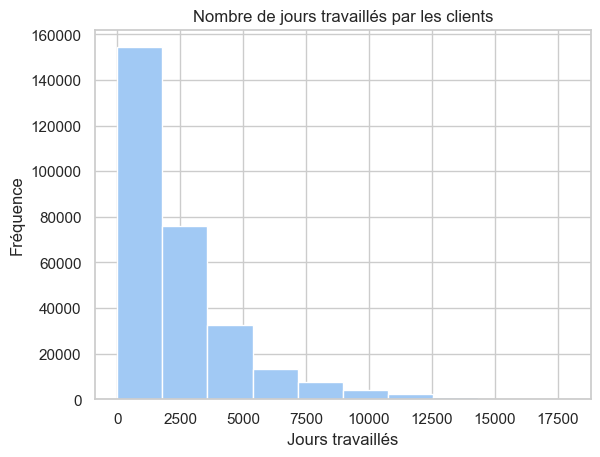

In [14]:
abs(df_data['DAYS_EMPLOYED']).plot.hist(title = 'Nombre de jours travaillés par les clients');
plt.xlabel('Jours travaillés');plt.ylabel('Fréquence');

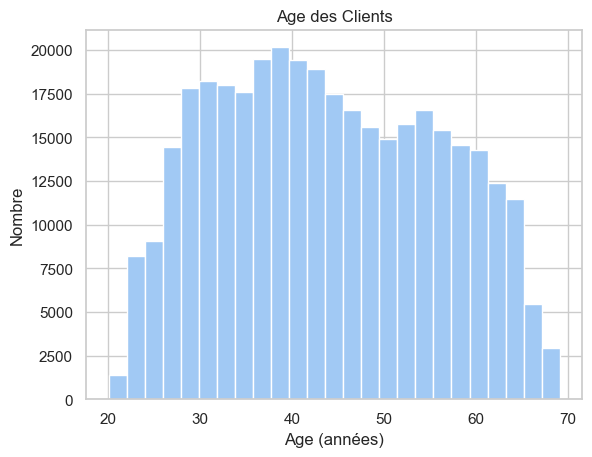

In [15]:
plt.hist(abs(df_data['DAYS_BIRTH'] / 365), bins = 25)
plt.title('Age des Clients'); plt.xlabel('Age (années)'); plt.ylabel('Nombre');

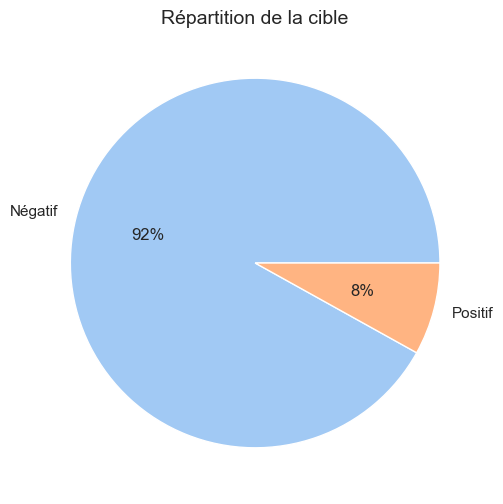

In [16]:
sns.set_style("darkgrid")
plt.figure(figsize=(14,6))
labels = ['Négatif','Positif']
plt.pie(df_data['TARGET'].value_counts(), labels=labels, autopct='%1.0f%%')
plt.title("Répartition de la cible", fontsize=14)
plt.show()

> la cible est très déséquilibrée

# Analyse des corrélations

Récupération de features - 0s
Extraction des données exploitables - 0s
Création des graphes - 0s


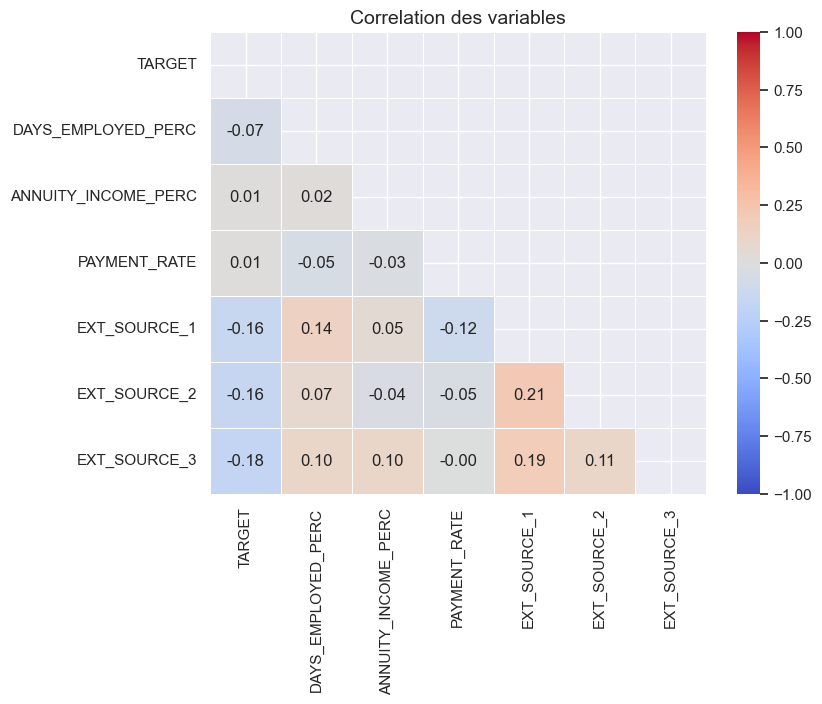

In [19]:
def séparationTrain(dataset):
    train = dataset[dataset['TARGET'].notnull()]
    return train

def graphCorr(dataset):
    data_corrs = dataset.corr()
    plt.figure(figsize = (8, 6))
    mask = np.triu(np.ones_like(data_corrs, dtype=bool))
    sns.heatmap(data_corrs, vmin=-1, vmax=1, cmap ='coolwarm', linewidths = 0.5, annot = True, fmt=".2f", mask = mask) 
    #sns.heatmap(data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -1, annot = True, vmax = 1)
    plt.title('Correlation des variables', fontsize=14);

def chercheCorrelations(dataset):
    """  """
    with timer("Récupération de features"):
        df_dataCorr = dataset[['TARGET','DAYS_EMPLOYED_PERC','ANNUITY_INCOME_PERC','PAYMENT_RATE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
    with timer("Extraction des données exploitables"):
        df_dataCorr = séparationTrain(df_dataCorr)
    with timer("Création des graphes"):
        graphCorr(df_dataCorr)

chercheCorrelations(df_data)

# Analyse Metier

# Analyse Metier

Visualisation des nouvelles variables :

ANNUITY_INCOME_PERC : le pourcentage de la rente du prêt par rapport au revenu du client

PAYMENT_RATE : la durée du paiement en mois (puisque la rente est le montant mensuel dû

DAYS_EMPLOYED_PERC : le pourcentage des jours employés par rapport à l'âge du client

Récupération des features Metier - 0s
Extraction des données exploitables - 0s
Création des graphes - 4s


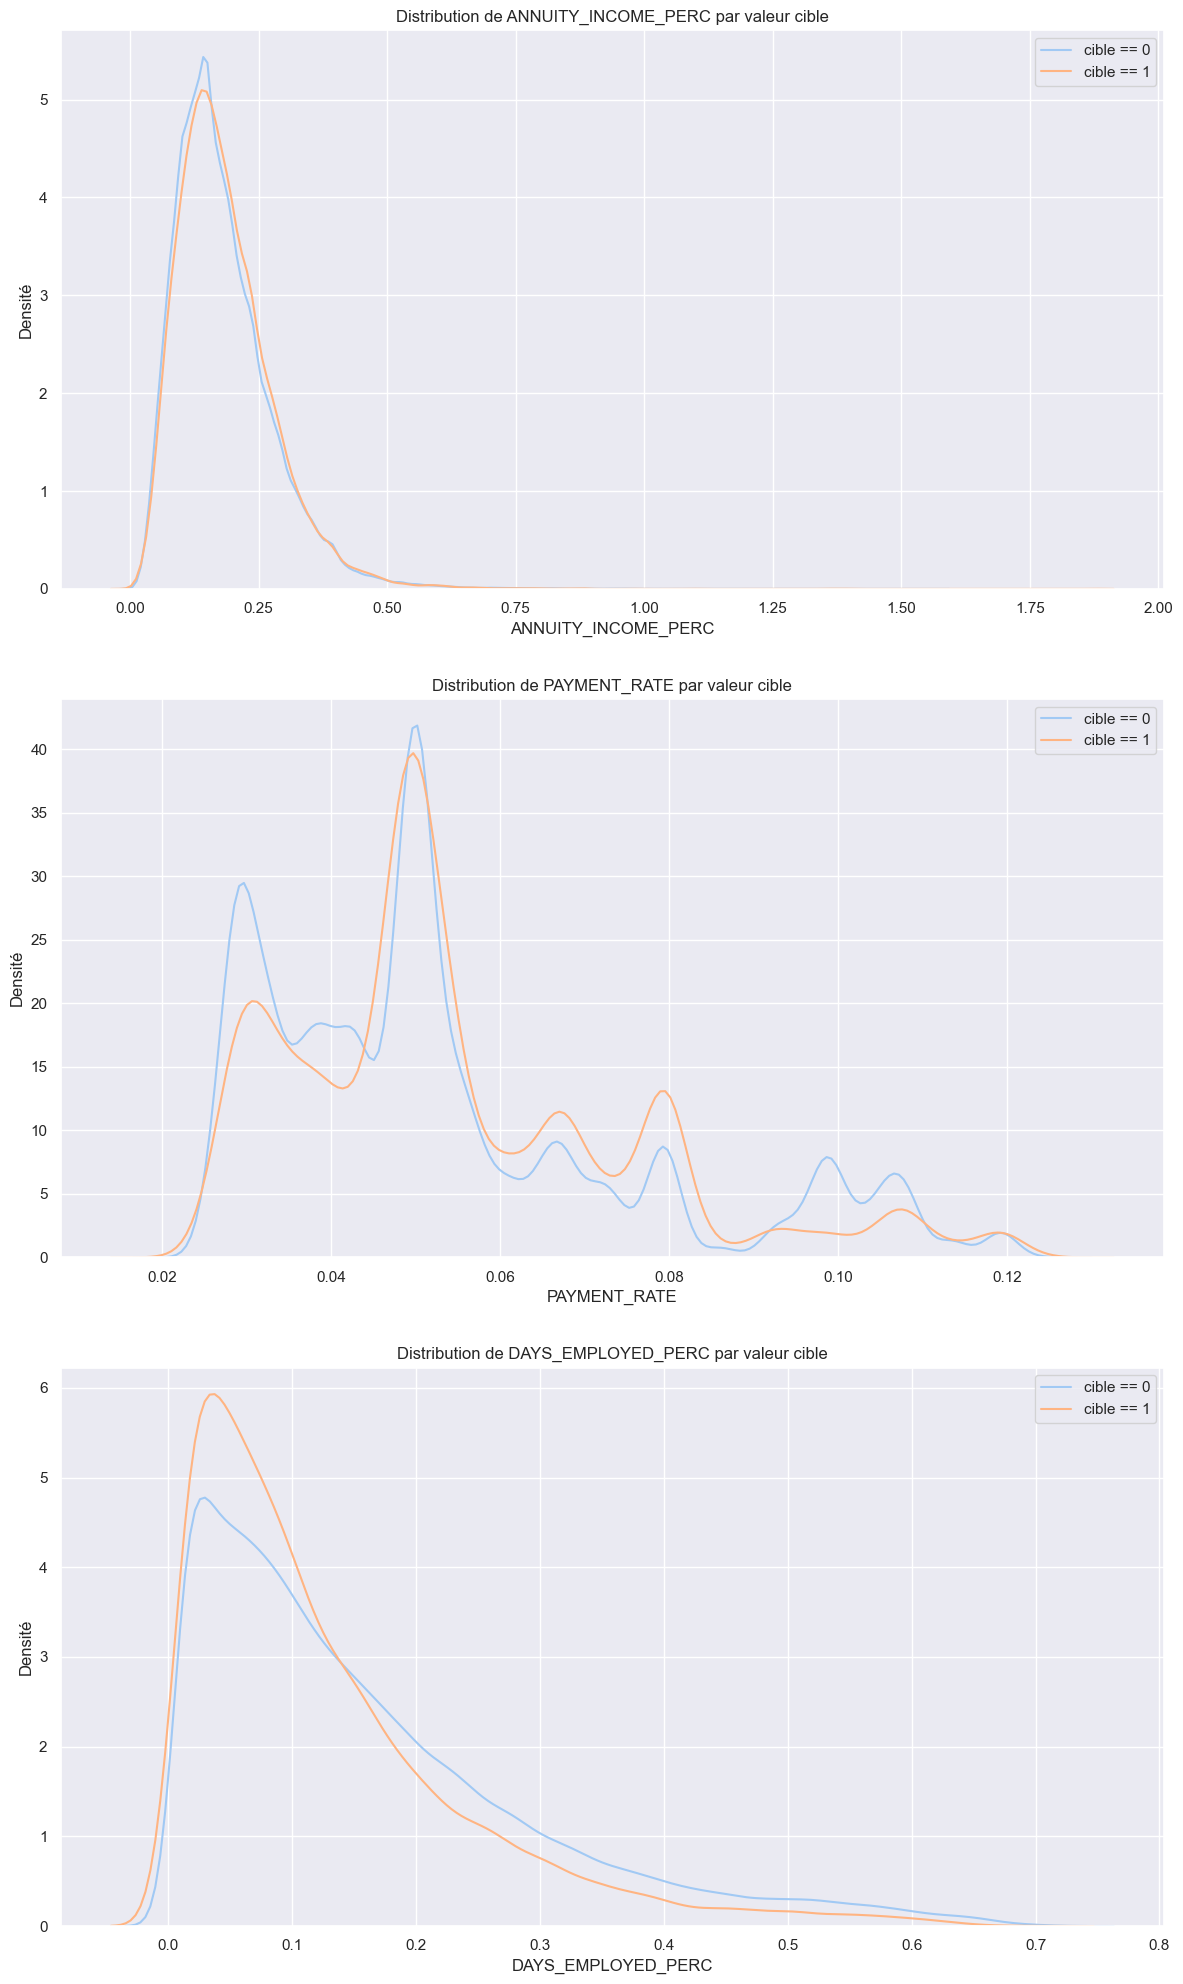

In [23]:
def séparationTrain(dataset):
    train = dataset[dataset['TARGET'].notnull()]
    return train

def graphMetier(dataset):
    plt.figure(figsize = (12, 20))
    # iterate through the new features
    for i, feature in enumerate(['ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'DAYS_EMPLOYED_PERC']):
        # create a new subplot for each source
        plt.subplot(3, 1, i + 1)
        # plot repaid loans
        sns.kdeplot(dataset.loc[dataset['TARGET'] == 0, feature], label = 'cible == 0')
        # plot loans that were not repaid
        sns.kdeplot(dataset.loc[dataset['TARGET'] == 1, feature], label = 'cible == 1')
        # Label the plots
        plt.title('Distribution de %s par valeur cible' % feature)
        plt.xlabel('%s' % feature); plt.ylabel('Densité'); plt.legend()
    plt.tight_layout(h_pad = 2.5)

def traitementMetier(dataset):
    """  """
    with timer("Récupération des features Metier"):
        df_dataMetier = dataset[['TARGET','DAYS_EMPLOYED_PERC','ANNUITY_INCOME_PERC','PAYMENT_RATE']]
    with timer("Extraction des données exploitables"):
        df_dataMetier = séparationTrain(df_dataMetier)
    with timer("Création des graphes"):
        graphMetier(df_dataMetier)

traitementMetier(df_data)

# Processing des données

In [25]:
def repartitionCibles(dataset, titre=""):
    """  """
    if not isinstance(dataset, pd.DataFrame):
        dataset = pd.DataFrame(dataset, columns = ['TARGET'])
    if 'TARGET' in dataset.columns:
        values = dataset['TARGET'].value_counts()
        val1 = values[1] / (values[0]+values[1])
        print(110*"-"+"\nRatio des valeurs cibles " + titre)
        print(f"valeurs positives {val1:.1%} ({values[1]})")
        print(f"valeurs négatives {(1-val1):.1%} ({values[0]})")
    else:
        print("Le dataset fourni ne comporte pas de cibles")

def filtreOuliers(dataset):
    """  """
    dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
    return dataset

def séparationTrain(dataset):
    train = dataset[dataset['TARGET'].notnull()]
    test = dataset[dataset['TARGET'].isnull()]
    saveFichierClient(test)
    saveFichierClientTrain(train)
    return train

def splitTrainTest(dataset):
    """  """
    dataset = dataset.drop(columns=['SK_ID_CURR'])
    target = dataset['TARGET']
    train, test = train_test_split(dataset, test_size=0.2,
                                   stratify=target, random_state=randomState)
    print(f"Données train shape: {train.shape}")
    print(f"Données test shape: {test.shape}")
    X_train = train.drop(columns=['TARGET'])
    X_test = test.drop(columns=['TARGET'])
    y_train = train['TARGET']
    y_test = test['TARGET']
    return X_train, X_test, y_train, y_test

def equilibrageDonnées(dataset, labels):
    """  """
    imputer = SimpleImputer(missing_values=np.NaN, strategy='median')
    dataset = imputer.fit_transform(dataset)
    smt = SMOTE(random_state=randomState)
    dataset_res, labels_res = smt.fit_resample(dataset, labels)
    return dataset_res, labels_res


def save2Csv(dataset,fichier):
    chunks = np.array_split(dataset.index, 100) # split into 100 chunks
    for chunck, subset in enumerate(tqdm(chunks)):
        if chunck == 0: # first row
            dataset.loc[subset].to_csv(fichier, mode='w', sep=',', index=False)
        else:
            dataset.loc[subset].to_csv(fichier, header=None, mode='a', sep=',', index=False)


def saveFichierClient(dataset):
    """  """
    with timer("sauvegarde des données application"):
        print("sauvegarde des données application")
        df_clients=dataset.sort_values(by='SK_ID_CURR', ascending=True)
        save2Csv(df_clients,FichierClient)
    with timer("sauvegarde échantillon des données"):
        print("sauvegarde échantillon des données")
        sample=df_clients.sample(50).sort_values(by='SK_ID_CURR', ascending=True)
        save2Csv(sample,FichierClientApi)


def saveFichierClientTrain(dataset):
    """  """
    with timer("sauvegarde des données train"):
        print("sauvegarde des données train")
        df_clientsTest=dataset.sort_values(by='SK_ID_CURR', ascending=True)
        save2Csv(df_clientsTest,FichierClientTrain)


def traitementDonnées(dataset):
    """  """
    repartitionCibles(dataset, 'pre traitement ')
    with timer("filtre ouliers"):
        dataset = filtreOuliers(dataset)
    with timer("séparation des données d\'entrainement'"):
        train = séparationTrain(dataset)
    with timer("split Train/Test des données"):
        X_train, X_test, y_train, y_test = splitTrainTest(train)
    with timer("équilibrage des données"):
        X_train_eq, y_train_eq = equilibrageDonnées(X_train, y_train)
    repartitionCibles(y_train, 'set de train ')
    repartitionCibles(y_train_eq, 'set de train_eq ')
    repartitionCibles(y_test, 'set de test ')
    return X_test, y_test, X_train, y_train, X_train_eq, y_train_eq

with timer(110*"-"+"\nProcessing "):
    X_test, y_test, X_train, y_train, X_train_eq, y_train_eq = traitementDonnées(df_data)

del df_data
gc.collect()

--------------------------------------------------------------------------------------------------------------
Ratio des valeurs cibles pre traitement 
valeurs positives 8.1% (24825)
valeurs négatives 91.9% (282682)
filtre ouliers - 1s
sauvegarde des données application


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [05:19<00:00,  3.20s/it]


sauvegarde des données application - 320s
sauvegarde échantillon des données


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 47.23it/s]


sauvegarde échantillon des données - 2s
sauvegarde des données train


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [31:16<00:00, 18.76s/it]


sauvegarde des données train - 1876s
séparation des données d'entrainement' - 2199s
Données train shape: (246005, 796)
Données test shape: (61502, 796)
split Train/Test des données - 2s
équilibrage des données - 31s
--------------------------------------------------------------------------------------------------------------
Ratio des valeurs cibles set de train 
valeurs positives 8.1% (19860)
valeurs négatives 91.9% (226145)
--------------------------------------------------------------------------------------------------------------
Ratio des valeurs cibles set de train_eq 
valeurs positives 50.0% (226145)
valeurs négatives 50.0% (226145)
--------------------------------------------------------------------------------------------------------------
Ratio des valeurs cibles set de test 
valeurs positives 8.1% (4965)
valeurs négatives 91.9% (56537)
--------------------------------------------------------------------------------------------------------------
Processing  - 2233s


11338

# Fonctions d'évaluation et sauvegarde des modéles

In [27]:
resultat=pd.DataFrame(columns=['Modèle', 'Description', 'AUC', 'Accuracy', 'Score Metier', 'Durée'])

def matriceConfusion(y_test, y_pred, nom="", descr=""):
    """
    Calcule les valeurs et pourcentages et
    Affiche une matrice de confusion avec 
    les données envoyées
    _______________entrées_______________
    y_reel : array des valeurs réélles
    y_pred : array des valeurs prédites
    titre  : titre affiché sur le graphe
    _______________sorties_______________
    affiche le graphe de la matrice de confusion
    """
    plt.figure(figsize=(5, 4))
    matrice = confusion_matrix(y_test, y_pred)
    noms_groupes = ['Vrai Neg','Faux Pos','Faux Neg','Vrai Pos']
    vals_groupes = ["{0:0.0f}".format(value) for value in matrice.flatten()]
    perc_groupes = ["{0:.2%}".format(value) for value in matrice.flatten()/np.sum(matrice)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(noms_groupes,vals_groupes,perc_groupes)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrice,
                annot=labels,
                fmt='',
                cmap=plt.cm.Blues,
                cbar=False)
    plt.title(f'Matrice de confusion: {nom}\n{descr}', pad=20)
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()

def scoreAuc(y_test, y_pred_prob, nom="", descr=""):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    score_auc_roc = roc_auc_score(y_test, y_pred_prob)
    plt.figure(figsize=(5, 4))
    plt.title(f'AUROC : {nom}\n{descr}', pad=20)
    plt.plot(fpr, tpr, label=r'(AUC = %0.4f)' % (score_auc_roc))
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.legend(loc="lower right")
    plt.show()
    return score_auc_roc

def scoreMet(y_test, y_pred, nom=""):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    score = (10*fn+fp)/((tn+fp+fn+tp)*10)
    return score

def evalModel(model, X_train, y_train, experiment_name, description=""):
    global resultat
    ModelName=str(model)[:str(model).rfind("(")]
    preprocessor=make_pipeline(SimpleImputer(missing_values = np.nan, strategy='median'),
                               StandardScaler())
    if mlflow.get_experiment_by_name(experiment_name) is None:
        mlflow.create_experiment(name=experiment_name)
    experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))['experiment_id']
    mlflow.autolog()
    with mlflow.start_run(run_name=ModelName, experiment_id=experiment_id, description=description):
        print(110*"-")
        print(f"Experimentation: {experiment_name}")
        print(f"Modèle tésté: {ModelName}")
        print(110*"-")
        model = make_pipeline(preprocessor, model)
        duree_fit_init = time.time()
        model.fit(X_train, y_train)
        duree_fit = time.time()-duree_fit_init
        y_pred = model.predict(X_test)
        y_train_prob = model.predict_proba(X_train)[:,1]
        y_pred_prob = model.predict_proba(X_test)[:,1]
        matriceConfusion(y_test, y_pred, nom=ModelName, descr=description)
        score_Auc = scoreAuc(y_test, y_pred_prob, nom=ModelName, descr=description)
        score_Acc = accuracy_score(y_test, y_pred)
        score_Metier = scoreMet(y_test, y_pred, nom=ModelName)
        mlflow.log_metric('scoreMetier', score_Metier)
        mlflow.log_metric('AUC', score_Auc)
        print(110*"-")
        print(classification_report(y_test, y_pred))
        print(110*"-")
        print(f"Score AUC:    {score_Auc}")
        print(f"Score Metier: {score_Metier}")
        print(f"Durée:        {duree_fit:.0f}s")
        print(110*"-")
        resultat = resultat._append({"Modèle": ModelName,
                                     "Description": description,
                                     "AUC": score_Auc,
                                     "Accuracy": score_Acc,
                                     "Score Metier": score_Metier,
                                     "Durée": duree_fit}, ignore_index=True)

# Etape1 - avec cible non équilibrée

## Modèle BaseLine

2025/01/17 19:24:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:24:55 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:24:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape1 - Balayage des modèles
Modèle tésté: DummyClassifier
--------------------------------------------------------------------------------------------------------------


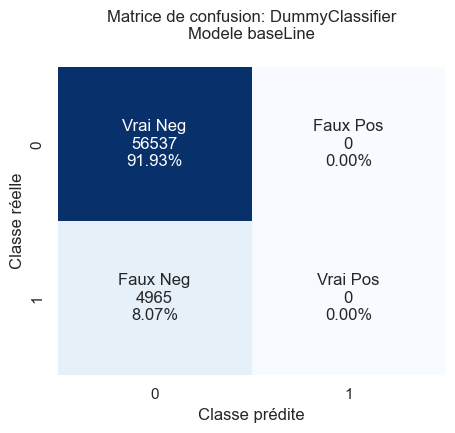

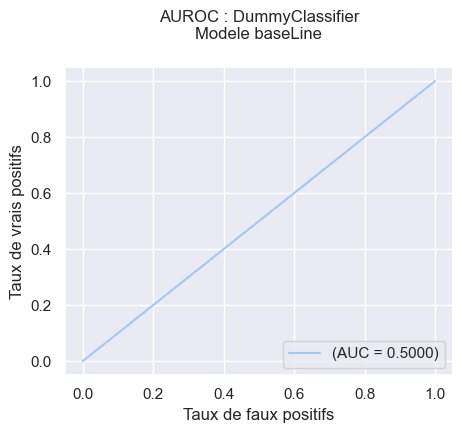

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.00      0.00      0.00      4965

    accuracy                           0.92     61502
   macro avg       0.46      0.50      0.48     61502
weighted avg       0.85      0.92      0.88     61502

--------------------------------------------------------------------------------------------------------------
Score AUC:    0.5
Score Metier: 0.08072908198107379
Durée:        92s
--------------------------------------------------------------------------------------------------------------
🏃 View run DummyClassifier at: http://10.0.50.72:5000/#/experiments/474795947144343231/runs/8d44490c614f45448ff2fb14ab8ac99a
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/474795947144343231


In [30]:
experiment_name = "Etape1 - Balayage des modèles"
Dummy = DummyClassifier(strategy='most_frequent')
evalModel(Dummy, X_train, y_train, experiment_name, description='Modele baseLine')

## Modèles sans classweight

2025/01/17 19:27:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:27:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:27:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape1 - Balayage des modèles
Modèle tésté: LogisticRegression
--------------------------------------------------------------------------------------------------------------


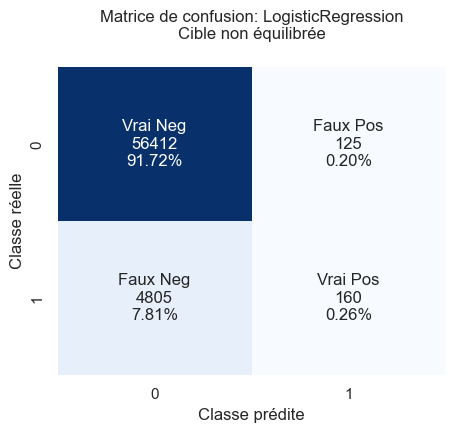

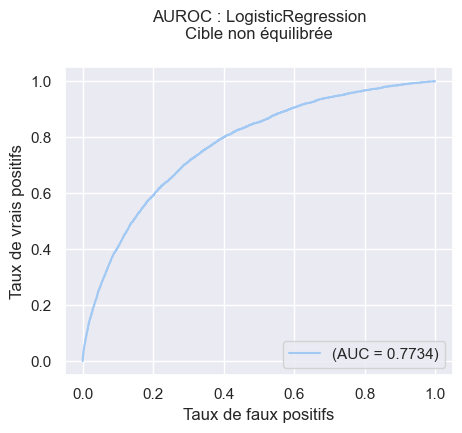

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.56      0.03      0.06      4965

    accuracy                           0.92     61502
   macro avg       0.74      0.52      0.51     61502
weighted avg       0.89      0.92      0.89     61502

--------------------------------------------------------------------------------------------------------------
Score AUC:    0.7734411285992057
Score Metier: 0.0783307859906995
Durée:        107s
--------------------------------------------------------------------------------------------------------------
🏃 View run LogisticRegression at: http://10.0.50.72:5000/#/experiments/474795947144343231/runs/97a98c4b88c54eb7b2ee8f2abbe45a18
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/474795947144343231


2025/01/17 19:30:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:30:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:30:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape1 - Balayage des modèles
Modèle tésté: LGBMClassifier
--------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.489747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469


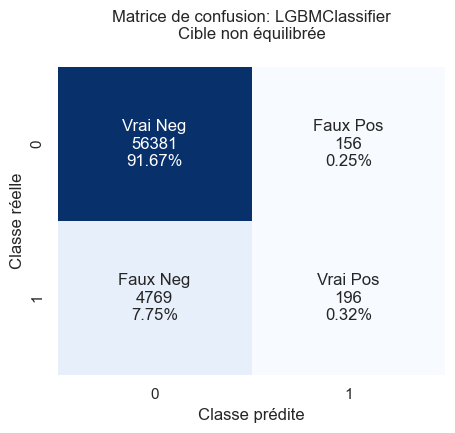

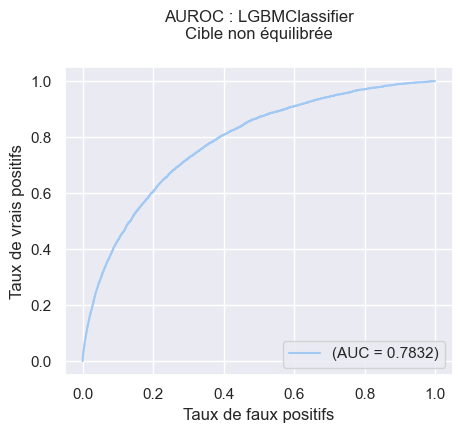

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.56      0.04      0.07      4965

    accuracy                           0.92     61502
   macro avg       0.74      0.52      0.52     61502
weighted avg       0.89      0.92      0.89     61502

--------------------------------------------------------------------------------------------------------------
Score AUC:    0.7831524600605106
Score Metier: 0.07779584403759228
Durée:        107s
--------------------------------------------------------------------------------------------------------------
🏃 View run LGBMClassifier at: http://10.0.50.72:5000/#/experiments/474795947144343231/runs/9434d24830b443e2961a9e7dbb2af666
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/474795947144343231


In [32]:
experiment_name = "Etape1 - Balayage des modèles"
Regression = LogisticRegression(random_state=randomState, n_jobs=-1)
evalModel(Regression, X_train, y_train, experiment_name, description="Cible non équilibrée")
LGBMClass = lgb.LGBMClassifier(random_state=randomState, n_jobs=-1)
evalModel(LGBMClass, X_train, y_train, experiment_name, description="Cible non équilibrée")

## Modèles avec classweight

2025/01/17 19:33:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:33:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:33:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape1 - Balayage des modèles
Modèle tésté: LogisticRegression
--------------------------------------------------------------------------------------------------------------


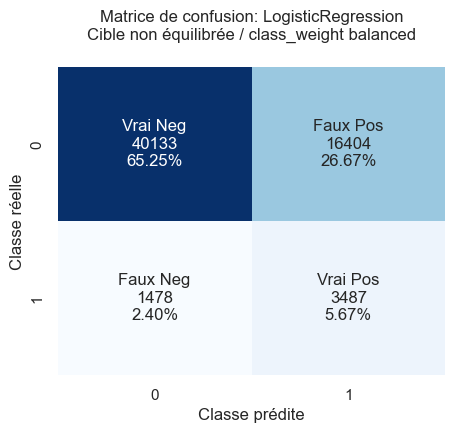

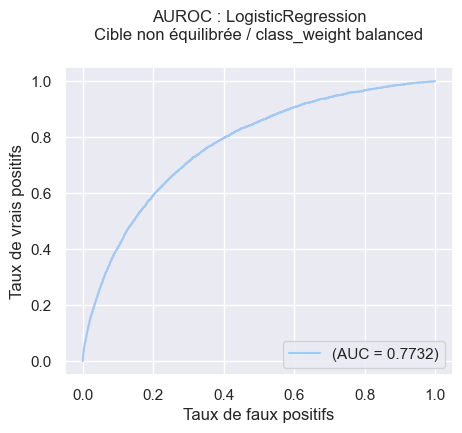

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56537
         1.0       0.18      0.70      0.28      4965

    accuracy                           0.71     61502
   macro avg       0.57      0.71      0.55     61502
weighted avg       0.90      0.71      0.77     61502

--------------------------------------------------------------------------------------------------------------
Score AUC:    0.7731723066114623
Score Metier: 0.050704042144970894
Durée:        107s
--------------------------------------------------------------------------------------------------------------
🏃 View run LogisticRegression at: http://10.0.50.72:5000/#/experiments/474795947144343231/runs/52bce2102f714e30a9cf063b46bfca94
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/474795947144343231


In [34]:
experiment_name = "Etape1 - Balayage des modèles"
Regression = LogisticRegression(class_weight='balanced', random_state=randomState, n_jobs=-1)
evalModel(Regression, X_train, y_train, experiment_name, description="Cible non équilibrée / class_weight balanced")

2025/01/17 19:35:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:35:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:35:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape1 - Balayage des modèles
Modèle tésté: LGBMClassifier
--------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.472282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469


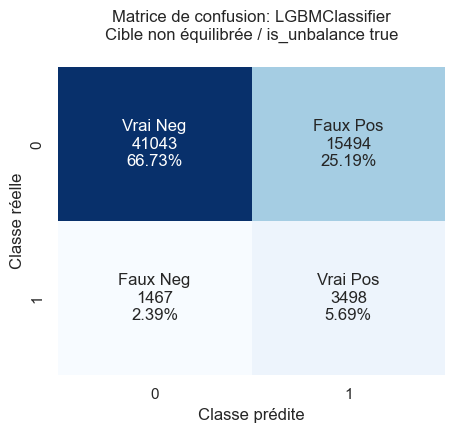

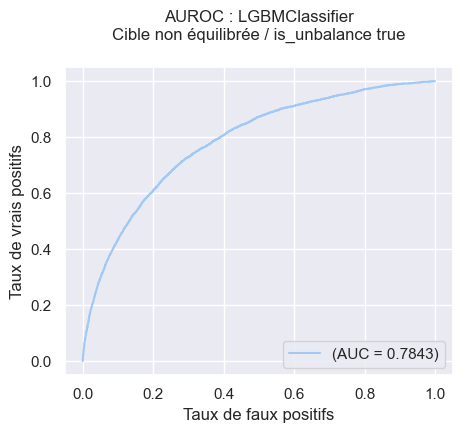

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.83     56537
         1.0       0.18      0.70      0.29      4965

    accuracy                           0.72     61502
   macro avg       0.57      0.72      0.56     61502
weighted avg       0.90      0.72      0.79     61502

--------------------------------------------------------------------------------------------------------------
Score AUC:    0.7843340691382295
Score Metier: 0.0490455594940002
Durée:        107s
--------------------------------------------------------------------------------------------------------------
🏃 View run LGBMClassifier at: http://10.0.50.72:5000/#/experiments/474795947144343231/runs/0ca62640a9214e3283222c269b7b4639
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/474795947144343231


In [35]:
experiment_name = "Etape1 - Balayage des modèles"
LGBMClass = lgb.LGBMClassifier(is_unbalance=True, random_state=randomState, n_jobs=-1)
evalModel(LGBMClass, X_train, y_train, experiment_name, description="Cible non équilibrée / is_unbalance true")

# Etape2 - avec cible équilibrée

## Modèles sans classweight

2025/01/17 19:38:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:38:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:38:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape1 - Balayage des modèles
Modèle tésté: LogisticRegression
--------------------------------------------------------------------------------------------------------------


2025/01/17 19:38:41 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


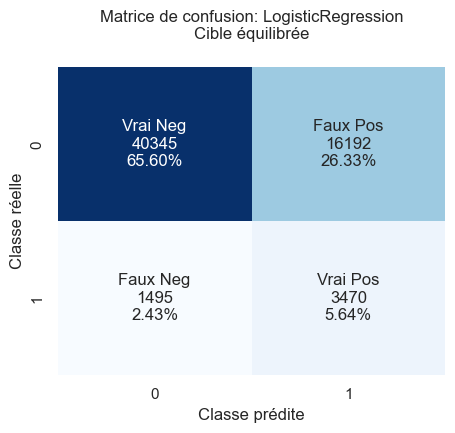

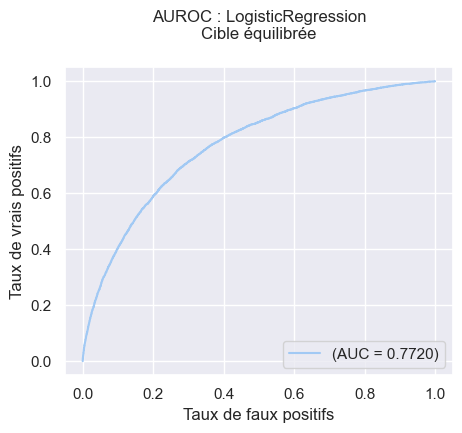

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56537
         1.0       0.18      0.70      0.28      4965

    accuracy                           0.71     61502
   macro avg       0.57      0.71      0.55     61502
weighted avg       0.90      0.71      0.78     61502

--------------------------------------------------------------------------------------------------------------
Score AUC:    0.7719947017202559
Score Metier: 0.0506357516828721
Durée:        144s
--------------------------------------------------------------------------------------------------------------
🏃 View run LogisticRegression at: http://10.0.50.72:5000/#/experiments/474795947144343231/runs/cb07e0088958453c8885a9d97f27e39e
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/474795947144343231


2025/01/17 19:41:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:41:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:41:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape1 - Balayage des modèles
Modèle tésté: LGBMClassifier
--------------------------------------------------------------------------------------------------------------


2025/01/17 19:41:33 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


[LightGBM] [Info] Number of positive: 226145, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.926473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171207
[LightGBM] [Info] Number of data points in the train set: 452290, number of used features: 743
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


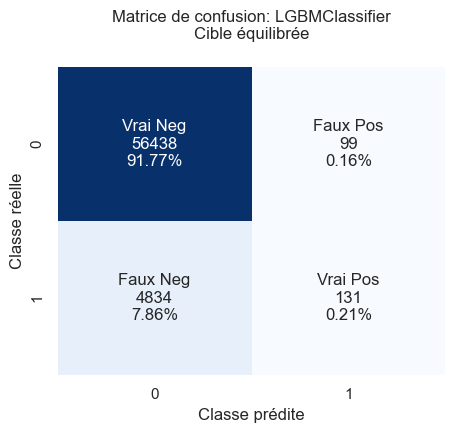

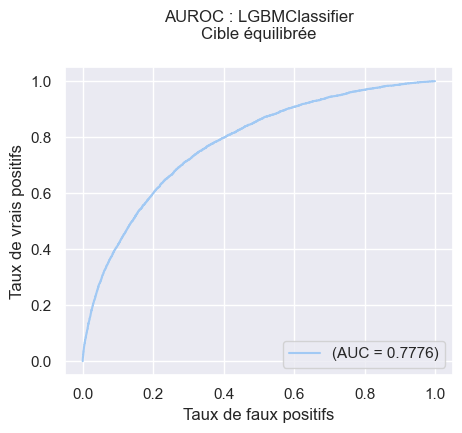

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.57      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.75      0.51      0.50     61502
weighted avg       0.89      0.92      0.88     61502

--------------------------------------------------------------------------------------------------------------
Score AUC:    0.7775978340058426
Score Metier: 0.0787600403238919
Durée:        203s
--------------------------------------------------------------------------------------------------------------
🏃 View run LGBMClassifier at: http://10.0.50.72:5000/#/experiments/474795947144343231/runs/2f15d18650ef42acb3952f4cbfaee81a
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/474795947144343231


In [38]:
experiment_name = "Etape1 - Balayage des modèles"
Regression = LogisticRegression(random_state=randomState, n_jobs=-1)
evalModel(Regression, X_train_eq, y_train_eq, experiment_name, description="Cible équilibrée")
LGBMClass = lgb.LGBMClassifier(random_state=randomState, n_jobs=-1)
evalModel(LGBMClass, X_train_eq, y_train_eq, experiment_name, description="Cible équilibrée")

# Choix du modèle

In [40]:
resultat

,Modèle,Description,AUC,Accuracy,Score Metier,Durée
0,DummyClassifier,Modele baseLine,0.500000,0.919271,0.080729,92.140393
1,LogisticRegression,Cible non équilibrée,0.773441,0.919840,0.078331,107.486002
2,LGBMClassifier,Cible non équilibrée,0.783152,0.919921,0.077796,106.552628
3,LogisticRegression,Cible non équilibrée / class_weight balanced,0.773172,0.709245,0.050704,107.447368
4,LGBMClassifier,Cible non équilibrée / is_unbalance true,0.784334,0.724220,0.049046,107.059683
5,LogisticRegression,Cible équilibrée,0.771995,0.712416,0.050636,143.631112
6,LGBMClassifier,Cible équilibrée,0.777598,0.919791,0.078760,203.482863


on peut observer que le dataset dont la cible est équilibrée favorise la régression Logistique
alors que la version non équilibrée avec l'option classweight=balaced est mieux interprétée par le LGBM.

Notre choix se portera sur ce dernier que nous allons optimiser

# Etape2 - Tunning du modéle choisi (GridSearch)

In [43]:
#Définition du scoring pour amélioration du modèle
Score_Met = make_scorer(scoreMet, greater_is_better=False)

In [44]:
def evalModelGrid(Modeles2Test, X_train, y_train, experiment_name, description=""):
    global resultat
    preprocessor=make_pipeline(SimpleImputer(missing_values = np.nan, strategy='median'),
                               StandardScaler())
    if mlflow.get_experiment_by_name(experiment_name) is None:
        mlflow.create_experiment(name=experiment_name)
    experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))['experiment_id']
    for ModeleAndParams in Modeles2Test:
        Modele2Test=ModeleAndParams[0]
        Params2Test=ModeleAndParams[1]
        ModelName=str(Modele2Test)[:str(Modele2Test).rfind("(")]
        mlflow.autolog()
        with mlflow.start_run(run_name=ModelName,
                              experiment_id=experiment_id,
                              description=description):
            print(110*"-")
            print(f"Experimentation: {experiment_name}")
            print(f"Modèle tésté: {ModelName}")
            print(f"Paramètres tésté: {Params2Test}")
            print(110*"-")
            model = make_pipeline(preprocessor, Modele2Test)
            modelGrid=GridSearchCV(model,
                                   param_grid=Params2Test,
                                   scoring=Score_Met,
                                   verbose=0,
                                   n_jobs=50,
                                   cv=3,
                                   return_train_score=True)
            duree_fit_init = time.time()
            modelGrid.fit(X_train, y_train)
            duree_fit = time.time()-duree_fit_init
            y_pred_train = modelGrid.best_estimator_.predict(X_train)
            y_pred_test = modelGrid.best_estimator_.predict(X_test)
            y_pred_train_prob = modelGrid.best_estimator_.predict_proba(X_train)[:,1]
            y_pred_test_prob = modelGrid.best_estimator_.predict_proba(X_test)[:,1]
            matriceConfusion(y_test, y_pred_test, nom=ModelName)
            score_Auc_train = scoreAuc(y_train, y_pred_train_prob, nom=ModelName+' Train')
            score_Auc_test = scoreAuc(y_test, y_pred_test_prob, nom=ModelName+' Test')
            score_Acc_train = accuracy_score(y_train, y_pred_train)
            score_Acc_test = accuracy_score(y_test, y_pred_test)
            score_Metier_train = scoreMet(y_train, y_pred_train, nom=ModelName)
            score_Metier_test = scoreMet(y_test, y_pred_test, nom=ModelName)
            mlflow.log_metric('AUC_Train', score_Auc_train)
            mlflow.log_metric('AUC', score_Auc_test)
            mlflow.log_metric('scoreMetier_Train', score_Metier_train)
            mlflow.log_metric('scoreMetier', score_Metier_test)
            print(110*"-")
            print(f"meilleurs paramètres : {modelGrid.best_params_}")
            #mlflow.log_params(modelGrid.best_params_)
            print(110*"-")
            print(classification_report(y_test, y_pred_test))
            print(110*"-")
            print(f"Score AUC Train:    {score_Auc_train}")
            print(f"Score AUC Test:     {score_Auc_test}")
            print(f"Score Metier Train: {score_Metier_train}")
            print(f"Score Metier Test:  {score_Metier_test}")
            print(f"Durée:              {duree_fit:.0f}s")
            print(110*"-")
            resultat = resultat._append({"Modèle": ModelName,
                                         "Description": description,
                                         "AUC": score_Auc_test,
                                         "Accuracy": score_Acc_test,
                                         "Score Metier": score_Metier_test,
                                         "Durée": duree_fit}, ignore_index=True)


In [45]:
# définition des modèles testés et de leurs hyperparamètres
Modeles2Test=[[LogisticRegression(),{
                  'logisticregression__random_state': [randomState],
                  'logisticregression__solver': ['lbfgs', 'sag', 'saga']}],
              [LGBMClassifier(),{
                  'lgbmclassifier__class_weight': ['balanced'],
                  'lgbmclassifier__n_estimators': [100, 200, 500],
                  'lgbmclassifier__colsample_bytree': [0.5, 0.7, 1],
                  'lgbmclassifier__max_depth': [2, 10, 30]}]]

Modeles2Test=[[LGBMClassifier(),{
                  'lgbmclassifier__random_state': [randomState],
                  'lgbmclassifier__is_unbalance': ['True'],
                  'lgbmclassifier__n_estimators': [200, 2000],
                  'lgbmclassifier__colsample_bytree': [0.5, 1],
                  'lgbmclassifier__max_depth': [1, 30]}]]

2025/01/17 19:45:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:45:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:45:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape2 - Grid search
Modèle tésté: LGBMClassifier
Paramètres tésté: {'lgbmclassifier__random_state': [42], 'lgbmclassifier__is_unbalance': ['True'], 'lgbmclassifier__n_estimators': [200, 2000], 'lgbmclassifier__colsample_bytree': [0.5, 1], 'lgbmclassifier__max_depth': [1, 30]}
--------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.359196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from s

2025/01/17 19:58:38 INFO mlflow.sklearn.utils: Logging the 5 best runs, 3 runs will be omitted.


🏃 View run aged-shrimp-100 at: http://10.0.50.72:5000/#/experiments/189117412336252391/runs/e7337a6a500a4ee19683459cbc8fc9eb
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/189117412336252391
🏃 View run burly-roo-202 at: http://10.0.50.72:5000/#/experiments/189117412336252391/runs/24911d71417645909996ce3772d5ad21
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/189117412336252391
🏃 View run resilient-croc-509 at: http://10.0.50.72:5000/#/experiments/189117412336252391/runs/fb3729bd0b6d4ea4bc5f420a6bc01b40
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/189117412336252391
🏃 View run lyrical-swan-450 at: http://10.0.50.72:5000/#/experiments/189117412336252391/runs/8658e6ad386a49fd8c384c08587bf39c
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/189117412336252391
🏃 View run lyrical-auk-816 at: http://10.0.50.72:5000/#/experiments/189117412336252391/runs/deb46912e2a04f6eaf54ff5c6ef87d71
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/18

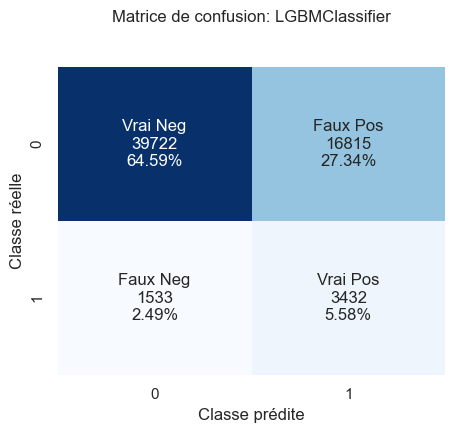

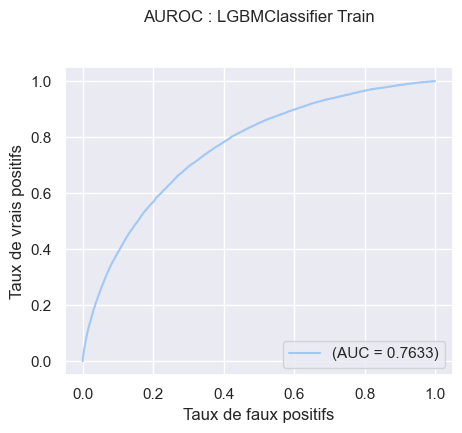

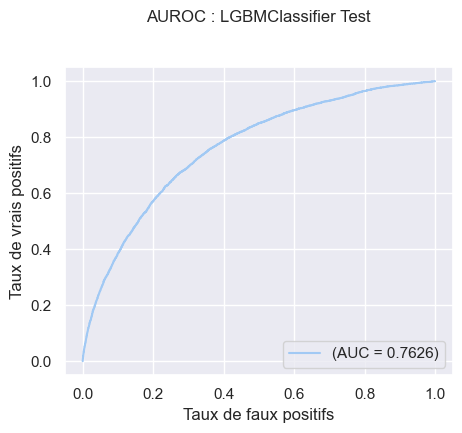

--------------------------------------------------------------------------------------------------------------
meilleurs paramètres : {'lgbmclassifier__colsample_bytree': 0.5, 'lgbmclassifier__is_unbalance': 'True', 'lgbmclassifier__max_depth': 1, 'lgbmclassifier__n_estimators': 200, 'lgbmclassifier__random_state': 42}
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56537
         1.0       0.17      0.69      0.27      4965

    accuracy                           0.70     61502
   macro avg       0.57      0.70      0.54     61502
weighted avg       0.90      0.70      0.77     61502

--------------------------------------------------------------------------------------------------------------
Score AUC Train:    0.7632678163447834
Score AUC Test:     0.7626382840379322
Score Metier Train: 0.052207068962012965
Score Metie

In [46]:
experiment_name = "Etape2 - Grid search"
evalModelGrid(Modeles2Test, X_train, y_train, experiment_name, description="Grid search / test params")

In [47]:
Modeles2Test=[[LGBMClassifier(),{
                  'lgbmclassifier__random_state': [randomState],
                  'lgbmclassifier__is_unbalance': ['True'],
                  'lgbmclassifier__learning_rate': [0.01],
                  'lgbmclassifier__n_estimators': [2000],
                  'lgbmclassifier__colsample_bytree': [0.8],
                  'lgbmclassifier__max_depth': [5]}]]

2025/01/17 19:58:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 19:58:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 19:58:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape2 - Grid search
Modèle tésté: LGBMClassifier
Paramètres tésté: {'lgbmclassifier__random_state': [42], 'lgbmclassifier__is_unbalance': ['True'], 'lgbmclassifier__learning_rate': [0.01], 'lgbmclassifier__n_estimators': [2000], 'lgbmclassifier__colsample_bytree': [0.8], 'lgbmclassifier__max_depth': [5]}
--------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.335545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM]

2025/01/17 20:05:53 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


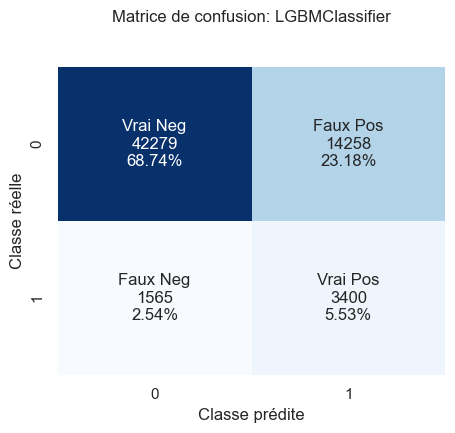

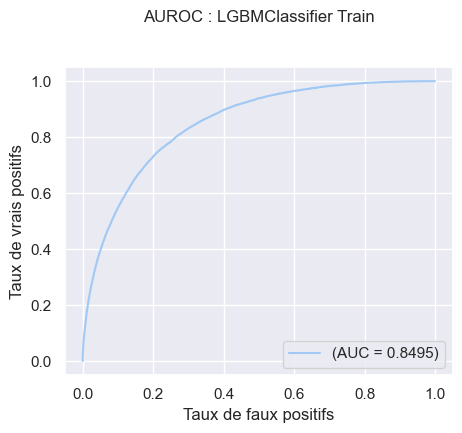

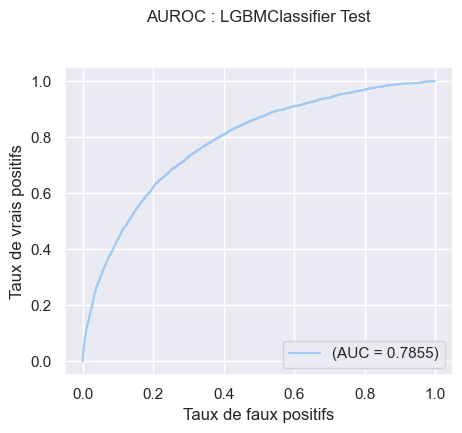

--------------------------------------------------------------------------------------------------------------
meilleurs paramètres : {'lgbmclassifier__colsample_bytree': 0.8, 'lgbmclassifier__is_unbalance': 'True', 'lgbmclassifier__learning_rate': 0.01, 'lgbmclassifier__max_depth': 5, 'lgbmclassifier__n_estimators': 2000, 'lgbmclassifier__random_state': 42}
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.75      0.84     56537
         1.0       0.19      0.68      0.30      4965

    accuracy                           0.74     61502
   macro avg       0.58      0.72      0.57     61502
weighted avg       0.90      0.74      0.80     61502

--------------------------------------------------------------------------------------------------------------
Score AUC Train:    0.8494918973039896
Score AUC Test:     0.7854740760005644
Score Metier

In [48]:
experiment_name = "Etape2 - Grid search"
evalModelGrid(Modeles2Test, X_train, y_train, experiment_name, description="Grid search / test params")

In [49]:
Modeles2Test=[[LGBMClassifier(),{
                  'lgbmclassifier__random_state': [randomState],
                  'lgbmclassifier__is_unbalance': ['True'],
                  'lgbmclassifier__learning_rate': [0.1],
                  'lgbmclassifier__n_estimators': [2000],
                  'lgbmclassifier__colsample_bytree': [0.7],
                  'lgbmclassifier__max_depth': [3]}]]

2025/01/17 20:06:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 20:06:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 20:06:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape2 - Grid search
Modèle tésté: LGBMClassifier
Paramètres tésté: {'lgbmclassifier__random_state': [42], 'lgbmclassifier__is_unbalance': ['True'], 'lgbmclassifier__learning_rate': [0.1], 'lgbmclassifier__n_estimators': [2000], 'lgbmclassifier__colsample_bytree': [0.7], 'lgbmclassifier__max_depth': [3]}
--------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.415997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] 

2025/01/17 20:11:05 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


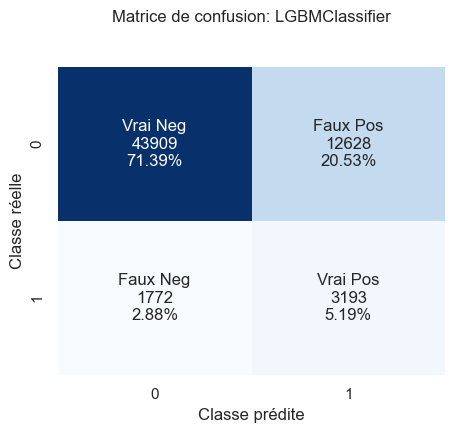

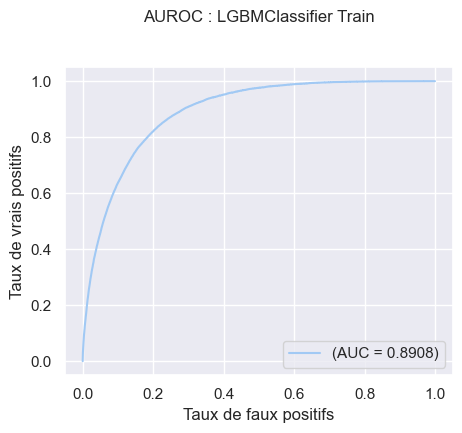

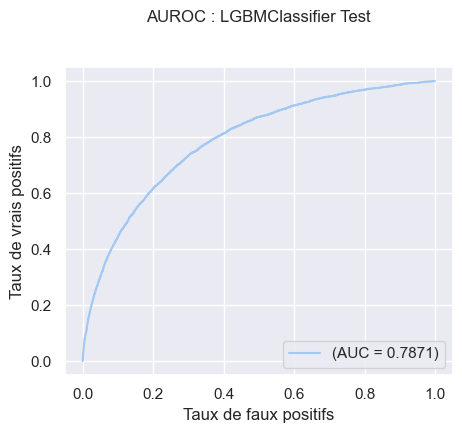

--------------------------------------------------------------------------------------------------------------
meilleurs paramètres : {'lgbmclassifier__colsample_bytree': 0.7, 'lgbmclassifier__is_unbalance': 'True', 'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 3, 'lgbmclassifier__n_estimators': 2000, 'lgbmclassifier__random_state': 42}
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     56537
         1.0       0.20      0.64      0.31      4965

    accuracy                           0.77     61502
   macro avg       0.58      0.71      0.58     61502
weighted avg       0.90      0.77      0.81     61502

--------------------------------------------------------------------------------------------------------------
Score AUC Train:    0.8907715137092327
Score AUC Test:     0.7870787715576149
Score Metier 

In [50]:
experiment_name = "Etape2 - Grid search"
evalModelGrid(Modeles2Test, X_train, y_train, experiment_name, description="Grid search / test params")

In [51]:
Modeles2Test=[[LGBMClassifier(),{
                  'lgbmclassifier__random_state': [randomState],
                  'lgbmclassifier__is_unbalance': ['True'],
                  'lgbmclassifier__learning_rate': [0.8],
                  'lgbmclassifier__n_estimators': [2000],
                  'lgbmclassifier__colsample_bytree': [0.6],
                  'lgbmclassifier__max_depth': [3]}]]

2025/01/17 20:11:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 20:11:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 20:11:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape2 - Grid search
Modèle tésté: LGBMClassifier
Paramètres tésté: {'lgbmclassifier__random_state': [42], 'lgbmclassifier__is_unbalance': ['True'], 'lgbmclassifier__learning_rate': [0.8], 'lgbmclassifier__n_estimators': [2000], 'lgbmclassifier__colsample_bytree': [0.6], 'lgbmclassifier__max_depth': [3]}
--------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.408716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99652
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 727
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] 

2025/01/17 20:16:50 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


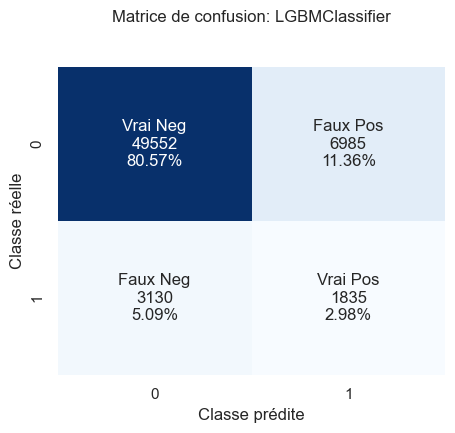

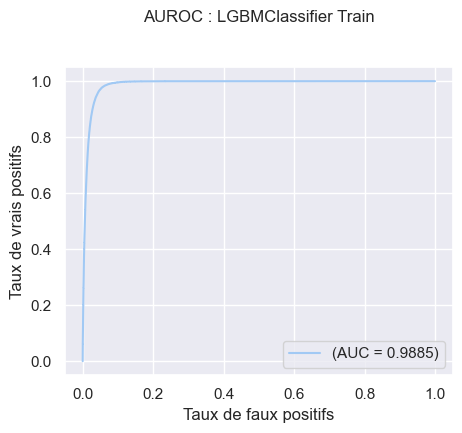

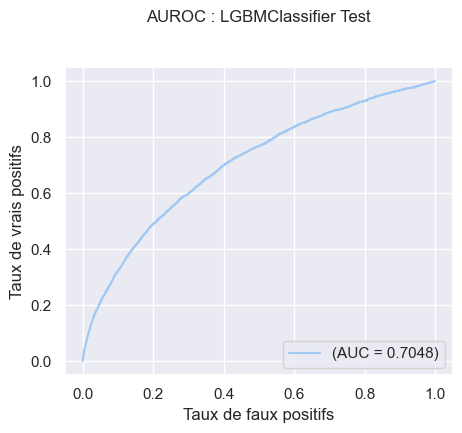

--------------------------------------------------------------------------------------------------------------
meilleurs paramètres : {'lgbmclassifier__colsample_bytree': 0.6, 'lgbmclassifier__is_unbalance': 'True', 'lgbmclassifier__learning_rate': 0.8, 'lgbmclassifier__max_depth': 3, 'lgbmclassifier__n_estimators': 2000, 'lgbmclassifier__random_state': 42}
--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91     56537
         1.0       0.21      0.37      0.27      4965

    accuracy                           0.84     61502
   macro avg       0.57      0.62      0.59     61502
weighted avg       0.88      0.84      0.86     61502

--------------------------------------------------------------------------------------------------------------
Score AUC Train:    0.9885183883639075
Score AUC Test:     0.7048372692723341
Score Metier 

In [52]:
experiment_name = "Etape2 - Grid search"
evalModelGrid(Modeles2Test, X_train, y_train, experiment_name, description="Grid search / test params")

# Inscription du modèle retenu dans le registre MlFlow

In [54]:
resultat

,Modèle,Description,AUC,Accuracy,Score Metier,Durée
0,DummyClassifier,Modele baseLine,0.500000,0.919271,0.080729,92.140393
1,LogisticRegression,Cible non équilibrée,0.773441,0.919840,0.078331,107.486002
2,LGBMClassifier,Cible non équilibrée,0.783152,0.919921,0.077796,106.552628
3,LogisticRegression,Cible non équilibrée / class_weight balanced,0.773172,0.709245,0.050704,107.447368
4,LGBMClassifier,Cible non équilibrée / is_unbalance true,0.784334,0.724220,0.049046,107.059683
5,LogisticRegression,Cible équilibrée,0.771995,0.712416,0.050636,143.631112
6,LGBMClassifier,Cible équilibrée,0.777598,0.919791,0.078760,203.482863
7,LGBMClassifier,Grid search / test params,0.762638,0.701668,0.052267,792.926658
8,LGBMClassifier,Grid search / test params,0.785474,0.742724,0.048629,422.064619
9,LGBMClassifier,Grid search / test params,0.787079,0.765861,0.049345,289.944334


> Nous passerons le modèle Tunné manuellement en regitered "PredictionCredit" sur MlFlow pour controler les performances

# Recupération id du dernier modele ajouté au registre

In [57]:
client = MlflowClient()
model_name = "PredictionCredit"
filter_string = f"name='{model_name}'"
results = client.search_registered_models(filter_string=filter_string)
print("-" * 110)
for res in results:
    for mv in res.latest_versions:
        print(f"name={mv.name}; run_id={mv.run_id}; version={mv.version}")
        RegisteredId = mv.run_id
print("-" * 110)

--------------------------------------------------------------------------------------------------------------
name=PredictionCredit; run_id=80802ce0eac34466aabcfc0a8283ab34; version=4
--------------------------------------------------------------------------------------------------------------


# Récuperation du modèle MlFlow

In [59]:
distribute_model = 'runs:/'+RegisteredId+'/model'
print(110*'-')
print(f'Récupération artifact: {distribute_model}')
meilleurModele = mlflow.sklearn.load_model(distribute_model)
print(110*'-')

--------------------------------------------------------------------------------------------------------------
Récupération artifact: runs:/80802ce0eac34466aabcfc0a8283ab34/model


--------------------------------------------------------------------------------------------------------------


# Affinage du seuil de décision

In [61]:
print(110*'-')
print(f'Calcul du score Metier en fonction du seuil:')
resultatSeuil = pd.DataFrame(columns=['seuil', 'scoreMet'])
for seuil in tqdm(np.linspace(0, 1, 200)):
    y_pred = meilleurModele.predict_proba(X_test)[:,1]>=seuil
    scoreMetTemp = scoreMet(y_test, y_pred)
    resultatSeuil = resultatSeuil._append({"seuil": seuil,
                                          "scoreMet": scoreMetTemp},
                                          ignore_index=True)
print(110*'-')
ScoreMin = resultatSeuil.min()[1]
Seuil = resultatSeuil.loc[resultatSeuil['scoreMet']==ScoreMin]['seuil'].squeeze()
print(f'Meilleur score Metier: {ScoreMin}    pour seuil: {Seuil}')
print(110*'-')
print(f'Sauvegarde du seuil: {Seuil} dans le fichier {FichierSeuilApi}')
if os.path.exists(FichierSeuilApi):
    os.remove(FichierSeuilApi)
fichier = open(FichierSeuilApi, "a")
fichier.write(str(Seuil))
fichier.close()
print(110*'-')



--------------------------------------------------------------------------------------------------------------
Calcul du score Metier en fonction du seuil:


100%|█████████████████████████████████████████████████████████████████████████████| 200/200 [06:29<00:00,  1.95s/it]

--------------------------------------------------------------------------------------------------------------
Meilleur score Metier: 0.04860004552697473    pour seuil: 0.5276381909547738
--------------------------------------------------------------------------------------------------------------
Sauvegarde du seuil: 0.5276381909547738 dans le fichier Api/Data/Seuil.txt
--------------------------------------------------------------------------------------------------------------


# Ultime évaluation du modèle Final

In [63]:
def evalModelFinal(model, X, y, seuil, experiment_name, description=""):
    ModelName='FinalModel'
    if mlflow.get_experiment_by_name(experiment_name) is None:
        mlflow.create_experiment(name=experiment_name)
    experiment_id = dict(mlflow.get_experiment_by_name(experiment_name))['experiment_id']
    mlflow.autolog()
    with mlflow.start_run(run_name=ModelName, experiment_id=experiment_id, description=description):
        print(110*"-")
        print(f"Experimentation: {experiment_name}")
        print(f"Modèle tésté: {ModelName}")
        print(110*"-")
        y_pred = model.predict_proba(X)[:,1]>=seuil
        y_pred_prob = model.predict_proba(X)[:,1]
        matriceConfusion(y, y_pred, nom=ModelName)
        score_Auc = scoreAuc(y, y_pred_prob, nom=ModelName, descr=description)
        score_Acc = accuracy_score(y, y_pred)
        score_Metier = scoreMet(y, y_pred, nom=ModelName)
        mlflow.log_metric('scoreMetier', score_Metier)
        mlflow.log_metric('AUC', score_Auc)
        print(110*"-")
        print(classification_report(y, y_pred))
        print(110*"-")
        print(f"Score Metier: {score_Metier}")
        print(110*"-")

2025/01/17 20:23:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/01/17 20:23:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/01/17 20:23:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


--------------------------------------------------------------------------------------------------------------
Experimentation: Etape3 - Modèle final
Modèle tésté: FinalModel
--------------------------------------------------------------------------------------------------------------


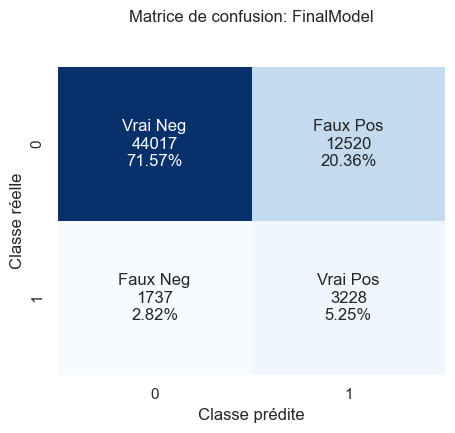

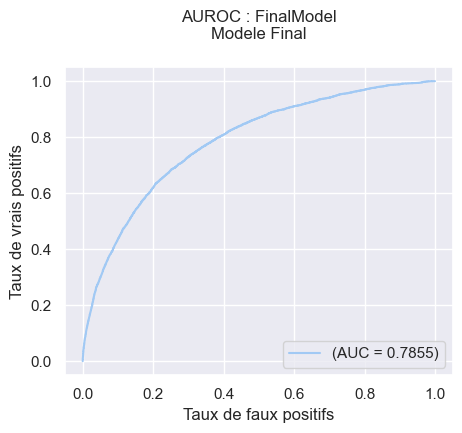

--------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     56537
         1.0       0.20      0.65      0.31      4965

    accuracy                           0.77     61502
   macro avg       0.58      0.71      0.59     61502
weighted avg       0.90      0.77      0.82     61502

--------------------------------------------------------------------------------------------------------------
Score Metier: 0.04860004552697473
--------------------------------------------------------------------------------------------------------------
🏃 View run FinalModel at: http://10.0.50.72:5000/#/experiments/146463750553333651/runs/28e0892dfbb24415995842c5e6280cb7
🧪 View experiment at: http://10.0.50.72:5000/#/experiments/146463750553333651


In [64]:
experiment_name = "Etape3 - Modèle final"
evalModelFinal(meilleurModele, X_test, y_test, Seuil, experiment_name, description='Modele Final')

# Publication du modèle vers API et Application

In [66]:
client = MlflowClient()
model_name = "PredictionCredit"
filter_string = f"name='{model_name}'"
results = client.search_registered_models(filter_string=filter_string)
print("-" * 110)
for res in results:
    for mv in res.latest_versions:
        print(f"name={mv.name}; run_id={mv.run_id}; version={mv.version}")
        RegisteredId = mv.run_id
print("-" * 110)
print(f'Verification si Artifact déjà présent: {FichierArtifactApi}')
if os.path.exists(FichierArtifactApi):
    print('Artifact déjà présent, on le supprime')
    shutil.rmtree(FichierArtifactApi)
else:
    print('pas d\'Artifact déjà présent')
print(110*'-')
finalModel = 'runs:/'+RegisteredId+'/model'
print(f'Publication artifact: {finalModel}')
finalModel = mlflow.sklearn.load_model(finalModel)
#mlflow.artifacts.download_artifacts(artifact_uri= distribute_model, run_id= None, dst_path= FichierArtifactApi) 
mlflow.sklearn.save_model(finalModel, FichierArtifactApi)
print(110*'-')
del finalModel
gc.collect()


--------------------------------------------------------------------------------------------------------------
name=PredictionCredit; run_id=80802ce0eac34466aabcfc0a8283ab34; version=4
--------------------------------------------------------------------------------------------------------------
Verification si Artifact déjà présent: Api/Data/Model
Artifact déjà présent, on le supprime
--------------------------------------------------------------------------------------------------------------
Publication artifact: runs:/80802ce0eac34466aabcfc0a8283ab34/model


--------------------------------------------------------------------------------------------------------------


4130

# Analyse du DataDrift

In [68]:
from evidently.test_suite import TestSuite
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

def DropColumns(dataset):
    if 'SK_ID_CURR' in dataset.columns:
        dataset = dataset.drop(['SK_ID_CURR'], axis=1)
    if 'TARGET' in dataset.columns:
        dataset = dataset.drop(['TARGET'], axis=1)
    return dataset

if 'train' not in globals():
    train = pd.read_csv(FichierClientTrain)
if 'df_clientsTest' not in globals():
    df_clientsTest = pd.read_csv(FichierClient)

train = DropColumns(train)
df_clientsTest = DropColumns(df_clientsTest)

In [69]:
data_drift_report = Report(metrics=[DataDriftPreset()])
data_drift_report.run(current_data=df_clientsTest, reference_data=train, column_mapping=None)
if os.path.exists(FichierDrift):
    os.remove(FichierDrift)
data_drift_report.save_html(FichierDrift)

> La visualisation du Drift se fait avec le fichier Appli/pages/Drift_du_Modèle.html

# Extraction de la Feature importance

In [72]:
def visualize_importance(modele, id, donnees):
    """calcule la feature importance du modele"""
    X = DropColumns(donnees)
    prediction = lambda x: modele.predict_proba(x)[:, 1]
    moyennes = X.mean().values.reshape((1, X.shape[1]))
    explainer = shap.Explainer(prediction, moyennes)
    shap_values_single = explainer(Client(id,donnees), max_evals=1500)
    shap_values = explainer(X, max_evals=1417)
    return shap_values_single, shap_values


def DropColumns(dataset):
    """enleve """
    if 'SK_ID_CURR' in dataset.columns:
        dataset = dataset.drop(['SK_ID_CURR'], axis=1)
    if 'TARGET' in dataset.columns:
        dataset = dataset.drop(['TARGET'], axis=1)
    return dataset


def loadModel():
    """retourne le modèle"""
    return pickle.load( open( pathMod+"model.pkl", "rb" ) )


def Client(id,dataset):
    """retourne les informations du client"""
    return DropColumns(dataset.loc[dataset.SK_ID_CURR == id])

In [73]:
import pickle

pathDb = 'Api/Data/Db/'
pathMod = 'Api/Data/Model/'
ClientsDatabase = pd.read_csv(pathDb+'ClientDatabase.csv')
ClientsList = ClientsDatabase['SK_ID_CURR'].tolist()

In [74]:
model = loadModel()
clientId = ClientsList[0]
shap_values_single, shap_values = visualize_importance(model, clientId, ClientsDatabase)

# Visualisation Importance globale

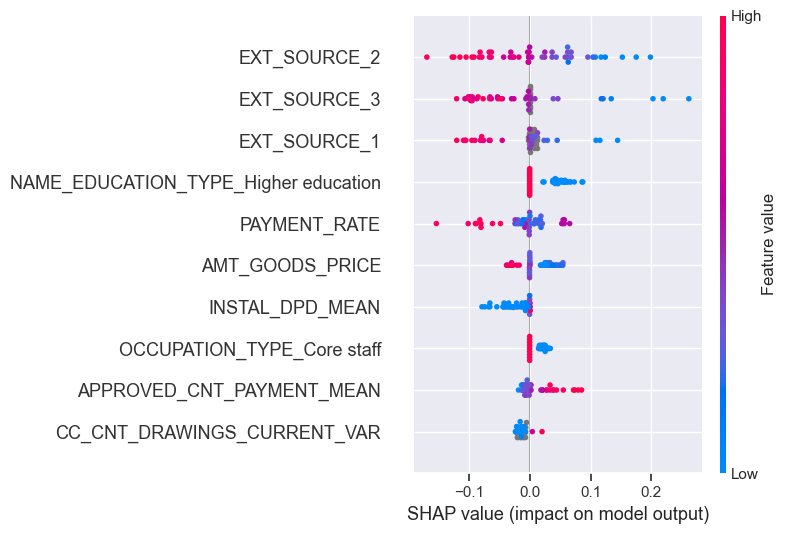

In [76]:
shap.summary_plot(shap_values, max_display=10)

# Visualisation Importance Locale

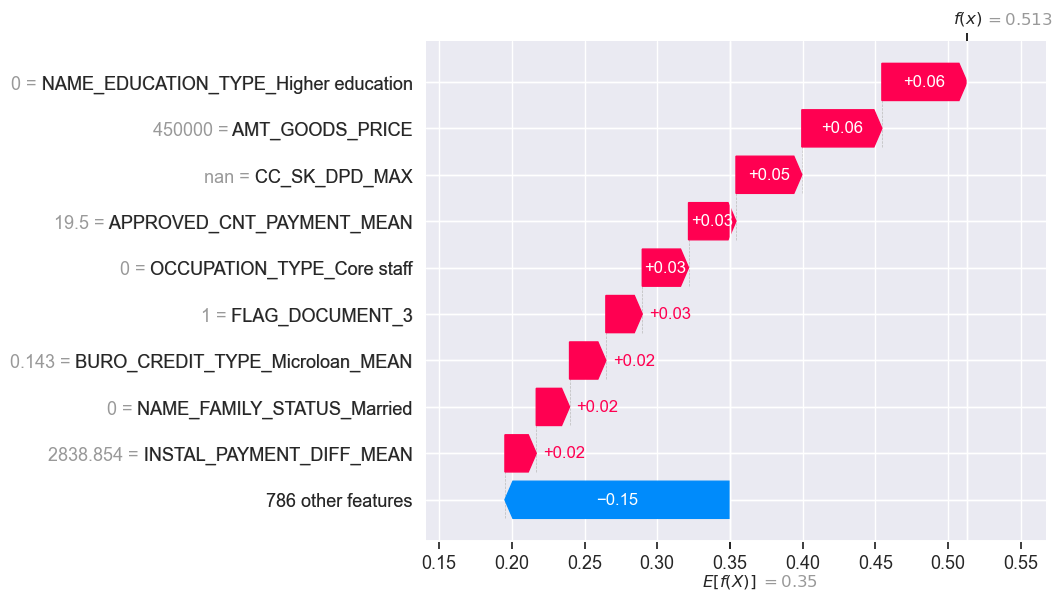

In [78]:
shap.plots.waterfall(shap_values_single[0], max_display=10)